In [1]:
import tensorflow as tf
from sklearn.datasets import make_moons
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import math
import flows

In [2]:
tf.set_random_seed(1234)
np.random.seed(1234)

In [3]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:
Please use tf.data.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
# X, y = make_moons(30000, noise=0.2)
# X = X.astype('float32')
# y = y.astype('float32')
# dataset = tf.data.Dataset.from_tensor_slices((X, y))
dataset = mnist.train
dataset = tf.data.Dataset.from_tensor_slices((dataset.images, dataset.labels))

In [5]:
dataset = dataset.shuffle(1000).repeat().batch(100)

In [6]:
diter = dataset.make_one_shot_iterator()

In [7]:
data, y = diter.get_next()#tf.Variable(X, trainable=False)

In [8]:
vae_hshape = [10,2]
    #784
vae = flows.dvae.DVAE(784, vae_hshape, config=[128,128])

In [9]:
data

<tf.Tensor 'IteratorGetNext:0' shape=(?, 784) dtype=float32>

In [10]:
_, encoded_hard = vae.encode(data)
encoded_soft, _ = vae.encode(data)
encoded_soft_conditioned, _ = vae.encode(data, condition=encoded_hard)

In [11]:
vae.logits

<tf.Tensor 'encoder_2/latent_inf/Reshape:0' shape=(?, 10, 2) dtype=float32>

In [12]:
sample_logp = tf.distributions.Multinomial(1., logits=vae.logits).log_prob(encoded_hard)
sample_logp = tf.reduce_sum(sample_logp, axis=-1)

In [13]:
decoded_soft = vae.decode(encoded_soft)
decoded_hard = vae.decode(encoded_hard)
decoded_soft_conditioned = vae.decode(encoded_soft_conditioned)

In [14]:
def rec_loss(x, dec):
    sigma = tf.constant(0.6)
    loss = tf.reduce_sum(tf.square(x - dec), axis=-1)/(2*tf.square(sigma)) - tf.log(2*3.14*sigma)
    return loss
def get_elbo(decoded):
    loss = rec_loss(data, decoded) + vae.kl_loss
    return -loss

In [15]:
soft_elbo = get_elbo(decoded_soft)
hard_elbo = get_elbo(decoded_hard)
soft_elbo_conditioned = get_elbo(decoded_soft_conditioned)

In [16]:
soft_elbo

<tf.Tensor 'Neg:0' shape=(?,) dtype=float32>

In [17]:
tf.summary.scalar('soft_elbo', tf.reduce_mean(soft_elbo))
tf.summary.scalar('hard_elbo', tf.reduce_mean(hard_elbo))

<tf.Tensor 'hard_elbo:0' shape=() dtype=string>

In [18]:
nvil_baseline = vae.build_nvil(data)

In [19]:
# hpr = vae_hshape[0]*vae_hshape[1]
# relax_uncond = vae.build_relax(tf.reshape(encoded_soft, [-1, hpr]))
# relax_cond = vae.build_relax(tf.reshape(encoded_soft_conditioned, [-1, hpr]))

In [20]:
encoder_vars = vae.get_encoder_vars()

In [21]:
eta = vae.eta

soft_control_cond = 0.#eta*soft_elbo_conditioned + relax_cond
soft_control_uncond = 0. #eta*soft_elbo - eta*soft_elbo_conditioned - relax_cond + relax_uncond

stoped_grad = hard_elbo - soft_control_cond - nvil_baseline

target = -sample_logp*stoped_grad - soft_control_uncond + vae.center_loss
target = tf.reduce_mean(target)

In [22]:
sample_logp, hard_elbo, soft_elbo

(<tf.Tensor 'Sum:0' shape=(?,) dtype=float32>,
 <tf.Tensor 'Neg_1:0' shape=(?,) dtype=float32>,
 <tf.Tensor 'Neg:0' shape=(?,) dtype=float32>)

In [23]:
grads_encoder = tf.gradients(target, encoder_vars, stop_gradients=stoped_grad)

In [24]:
controls_loss = vae.build_control_loss(grads_encoder)
tf.summary.scalar('controls_loss', controls_loss)

<tf.Tensor 'controls_loss:0' shape=() dtype=string>

In [25]:
decoder_vars = vae.get_decoder_vars()

In [26]:
grads_decoder = tf.gradients(-hard_elbo, decoder_vars)

In [27]:
# pretemperature, preeta, controls_loss

In [28]:
with tf.name_scope('var_reductions'):
    control_vars = vae.get_control_vars()
    loss = controls_loss
    grads_reds = tf.gradients(loss, control_vars)
gvs_reds = [(g,v) for g,v in zip(grads_reds, control_vars)]

In [29]:
control_vars

[<tf.Variable 'VAE/controls/pretemp:0' shape=(10, 2) dtype=float32_ref>,
 <tf.Variable 'VAE/controls/preeta:0' shape=() dtype=float32_ref>,
 <tf.Variable 'VAE/controls/NVIL/FCN/d0/W:0' shape=(784, 128) dtype=float32_ref>,
 <tf.Variable 'VAE/controls/NVIL/FCN/d0/b:0' shape=(1, 128) dtype=float32_ref>,
 <tf.Variable 'VAE/controls/NVIL/FCN/d1/W:0' shape=(784, 64) dtype=float32_ref>,
 <tf.Variable 'VAE/controls/NVIL/FCN/d1/b:0' shape=(1, 64) dtype=float32_ref>,
 <tf.Variable 'VAE/controls/NVIL/FCN/d2/W:0' shape=(784, 1) dtype=float32_ref>,
 <tf.Variable 'VAE/controls/NVIL/FCN/d2/b:0' shape=(1, 1) dtype=float32_ref>]

In [30]:
variables = encoder_vars + decoder_vars
grads = grads_encoder + grads_decoder
gvs = [(g,v) for g,v in zip(grads, variables)]

In [31]:
with tf.control_dependencies([tf.check_numerics(g, message='Numerics trouble') for g,x in gvs]):
    main_op = tf.train.AdamOptimizer(0.001).apply_gradients(gvs)
red_op = tf.train.AdamOptimizer(0.002).apply_gradients(gvs_reds)

In [32]:
train_op = [main_op, red_op]

In [33]:
# !rm -R /tmp/tfdbg

In [34]:
sess = tf.InteractiveSession()
writer = tf.summary.FileWriter('/tmp/tfdbg/nvil_baseline', tf.get_default_graph())
init = tf.global_variables_initializer()

In [35]:
init.run()

In [36]:
all_summaries = tf.summary.merge_all()

In [37]:
step = 0

In [38]:
for step in range(step, 600000):
    _, sm = sess.run([train_op, all_summaries])
    if step % 20 == 0:
        writer.add_summary(sm, global_step=step)
    if step % 1000 == 0:
        print(step)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000


KeyboardInterrupt: 

In [40]:
prior = tf.distributions.Multinomial(1., logits=tf.zeros([10]+vae.hshape)).sample()
generated = vae.decode(prior)

In [41]:
tt = np.reshape(generated.eval(), [-1,28,28])

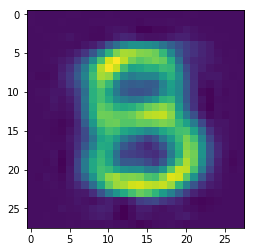

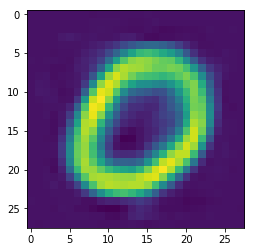

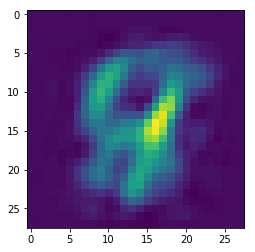

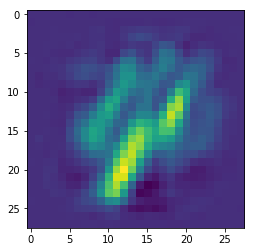

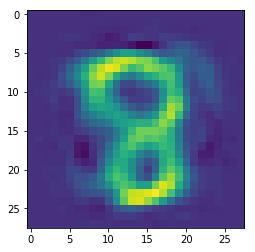

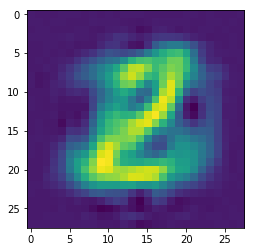

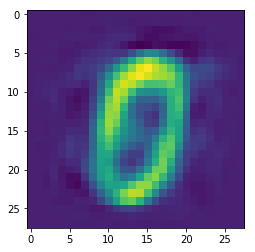

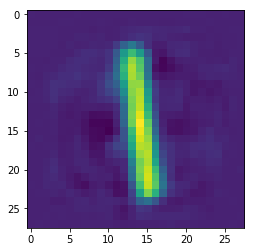

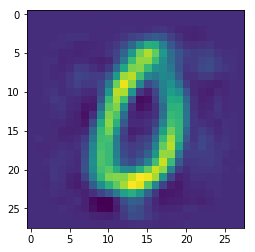

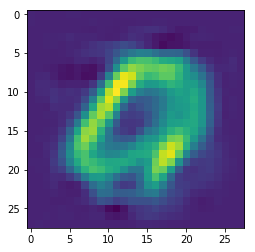

In [42]:
for i in range(10):
    plt.imshow(tt[i])
    plt.show()

In [ ]:
pretemperature.assign(math.log(.4)).eval()